# Batters

Now that I have my tables cleaned, combined and ready for analysis it's time to get a better understanding of the data and make any final changes to remove outliers or unnecessary columns. This notebook will be solely focused on batters, I will have a separate notebook for the pitchers that will follow along a very similar process to this one.

## Data Preparation

In [1]:
# Import necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition, svm
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")

/Users/derekdavis/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/Users/derekdavis/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [130]:
# Visualize the impact of a few key metrics on Hall of Fame inclusivity 
def comparative_graph(s):
    cat, num = 'inducted', s
    fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False, figsize=(20, 7))
    fig.suptitle(s + ' vs Inducted', fontsize=20)

    # Create a distribution graph to compare HOF inducted players against those not inducted by a certain metric.
    ax[0].title.set_text('density')
    for i in df[cat].unique():
        sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
    ax[0].grid(True)
    
    # Create a stacked bar graph containing 10 bins to help visualize the divide between the two classes of players.
    ax[1].title.set_text('bins')
    breaks = np.quantile(df[num], q=np.linspace(0,1,11))
    tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
    tmp = tmp[df[cat].unique()]
    tmp["tot"] = tmp.sum(axis=1)
    for col in tmp.drop("tot", axis=1).columns:
         tmp[col] = tmp[col] / tmp["tot"]
    tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
    
    # Create a boxplot to compare HOF inducted players against those not inducted and to visualize outliers.   
    ax[2].title.set_text('outliers')
    sns.boxplot(x=cat, y=num, data=df, ax=ax[2])
    ax[2].grid(True)
    plt.savefig(s)
    plt.show();

    
# Create a new correlated dataframe with absolute value of a number,
def high_corr(df):
    df_highcorr = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df_highcorr['Highly Correlated Pairs'] = list(zip(df_highcorr.level_0, df_highcorr.level_1))
    df_highcorr.set_index(['Highly Correlated Pairs'], inplace = True)
    df_highcorr.drop(columns=['level_1', 'level_0'], inplace = True)
    df_highcorr.columns = ['Correlation']
    df_highcorr.drop_duplicates(inplace=True)
    return df_highcorr[(df_highcorr.Correlation>.7) & (df_highcorr.Correlation<1)]
    
# Create function used to find Precision, Recall, Accuracy, and F1 Scores.
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
# Find the optimal K value for KNN models.
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k 
            best_score = f1
            
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

# Create a function that visualizes the confusion matrix for the model.    
def plot_cm(model):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.grid(False)
    plot_confusion_matrix(model, X_test, y_test, cmap='Greens', ax=ax)
    
# Create function for performing log transformations.
def log_transform(df,features):
    '''Runs a log transformation on a feature
    
        @params
        df is a pd.Dataframe
        features is a list of columns to be considered
        
        @output
        new log-transformed column
    
    '''
    for feature in features:
        df[feature + '_log'] = np.log(df[feature]+1)
    return df 

In [3]:
#Import eligible_batters from cleaning notebook
batters_df = pd.read_csv('eligible_batters.csv')
batters_df['inducted'] = batters_df['inducted'].apply(lambda x: 1 if x == 'Y' else 0) # numerical boolean
batters_df

,playerID,Seasons,fullName,G,AB,R,H,2B,3B,HR,...,FP,Cy Young,Gold Glove,Hank Aaron,Most Valuable Player,Rolaids Relief Man Award,Rookie of the Year,Silver Slugger,ASG,inducted
0,aaronha01,23,Hank Aaron,3298,12364,2174,3771,624,98,755,...,0.98,0.0,3.0,0.0,1.0,0.0,0.0,0.0,24.0,1
1,abbated01,10,Ed Abbaticchio,855,3044,355,772,99,43,11,...,0.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,abreubo01,20,Bobby Abreu,2425,8480,1453,2470,574,59,288,...,0.98,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0
3,adairje01,15,Jerry Adair,1165,4019,378,1022,163,19,57,...,0.98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,adamsbo03,15,Bobby Adams,1281,4019,591,1082,188,49,37,...,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,zernigu01,12,Gus Zernial,1234,4131,572,1093,159,22,237,...,0.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1617,zimmech01,20,Chief Zimmer,1280,4546,617,1225,222,76,26,...,0.95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1618,zimmedo01,14,Don Zimmer,1095,3283,353,773,130,22,91,...,0.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0
1619,zimmehe01,14,Heinie Zimmerman,1456,5304,695,1566,275,105,58,...,0.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
# View all the columns in the DataFrame.
list(batters_df)

['playerID',
 'Seasons',
 'fullName',
 'G',
 'AB',
 'R',
 'H',
 '2B',
 '3B',
 'HR',
 'RBI',
 'SB',
 'CS',
 'BB',
 'SO',
 'HBP',
 'SF',
 'walks',
 'BA',
 'OBP',
 '1B',
 'SLUG',
 'OPS',
 'Position',
 'PO',
 'A',
 'E',
 'FP',
 'Cy Young',
 'Gold Glove',
 'Hank Aaron',
 'Most Valuable Player',
 'Rolaids Relief Man Award',
 'Rookie of the Year',
 'Silver Slugger',
 'ASG',
 'inducted']

One of the first things that I want to consider is how the Steroids Era in baseball, a period from 1993-2002, might impact our analysis. There are several players who on paper would be first ballot Hall of Famers; however, due to steroid use have failed to recieve enough votes. This will have a significant impact on the models in this notebook as some of the best hitters have been held out due to steroid usage. These would be outliers that would skew the results for some of the models and for that reason will be removed. I am also going to remove Shoeless Joe Jackson and Pete Rose from this list as well as they are two of the best players but have been held out due to actions that compromised the integrity of the game.

In [5]:
# Remove players from the DataFrame.
batters_df = batters_df[(batters_df['fullName']!='Barry Bonds') & (batters_df['fullName']!='Rafael Palmeiro')
                        & (batters_df['fullName']!='Mark McGwire') & (batters_df['fullName']!='Sammy Sosa') 
                        & (batters_df['fullName']!='Pete Rose') & (batters_df['fullName']!='Manny Ramirez') 
                        & (batters_df['fullName']!='Gary Sheffield') & (batters_df['fullName']!='Shoeless Joe Jackson')]

In [6]:
# Drop unnecessary columns.
df = batters_df.drop(columns=['playerID', 'fullName', 'Position', 'Cy Young', 'Rolaids Relief Man Award'])

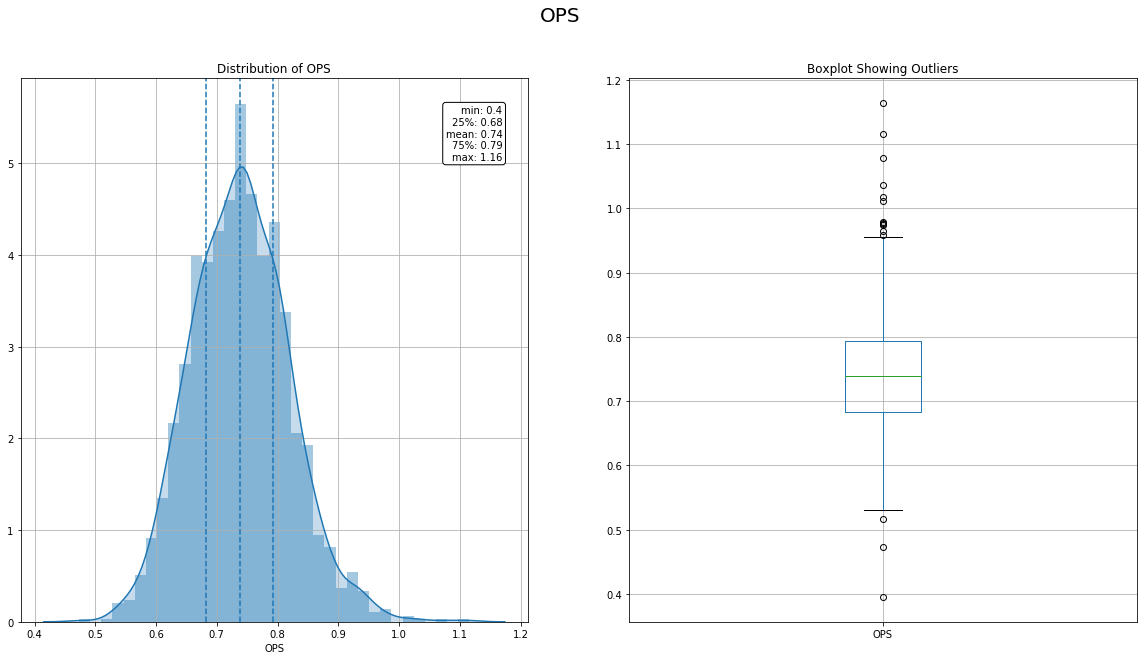

In [7]:
# Create two graphs, a Distribution and Boxplot comparing OPS across all batters.
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(20,10))
fig.suptitle('OPS', fontsize=20)

# Create Distribution Showing OPS across all eligible for the HOF
ax[0].title.set_text('Distribution of OPS')
variable = df['OPS'].fillna(df['OPS'].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df['OPS'].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

# Create a Boxplot showing Outliers.
ax[1].title.set_text('Boxplot Showing Outliers')
df.boxplot(column='OPS', ax=ax[1])
plt.show()

Now I am going to look at a few of the other key metrics and analyze them with our comparative graph function I created earlier. This will show us how those elected to the Hall of Fame compare to those who were not. Keep in mind, that all players in this analysis have played for 10 years or more suggesting that even those not elected have had very successful careers.

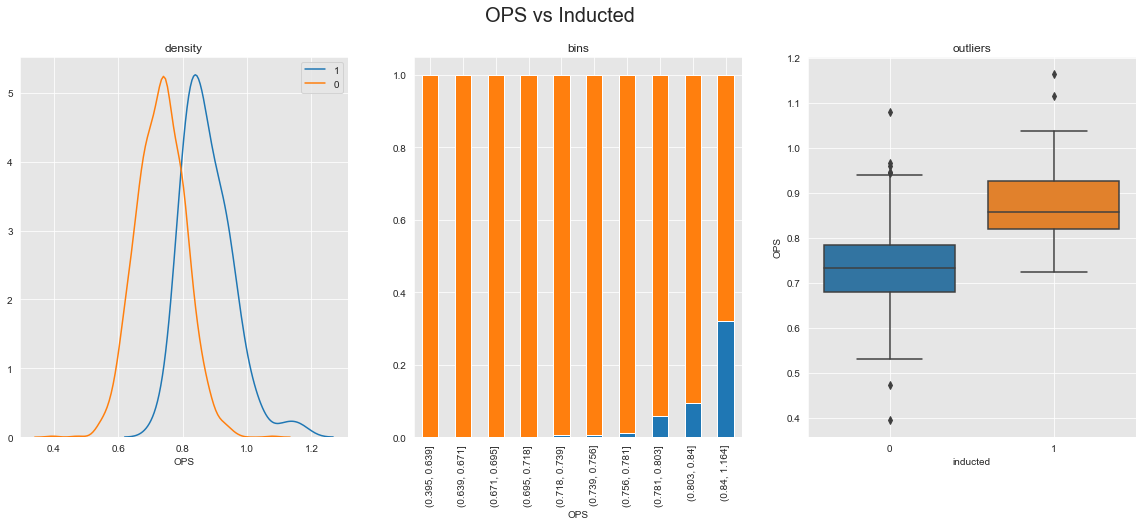

In [131]:
# First take a look at OPS.
comparative_graph('OPS')

OPS is a great measure of a players hitting ability. It is built from both on-base percentage and slugging percentage. A high on-base percentage is a good indicator that a player can hit well for contact and draw a lot of walks, a high slugging percentage indicates that a player can hit for power. When a player has a high OPS it's a representation of their impressive ability to hit for both power and contact. As we can see here players inducted into the Hall of Fame typically have a much significantly higher OPS.

One other thing to note that we can see in the bar graph is that a few Hall of Fame players have an OPS of less than .700. We can assume that these are pitchers who have had over 2500 career at bats and should be removed from the DataFrame.

In [125]:
# Create a pitchers table from players elected to the Hall of Fame with less than a .700 OPS
pitchers = df[(df['OPS']<.7) & (df['inducted']==1)].index

# Drop the pitchers from the DataFrame.
df.drop(pitchers, inplace=True)

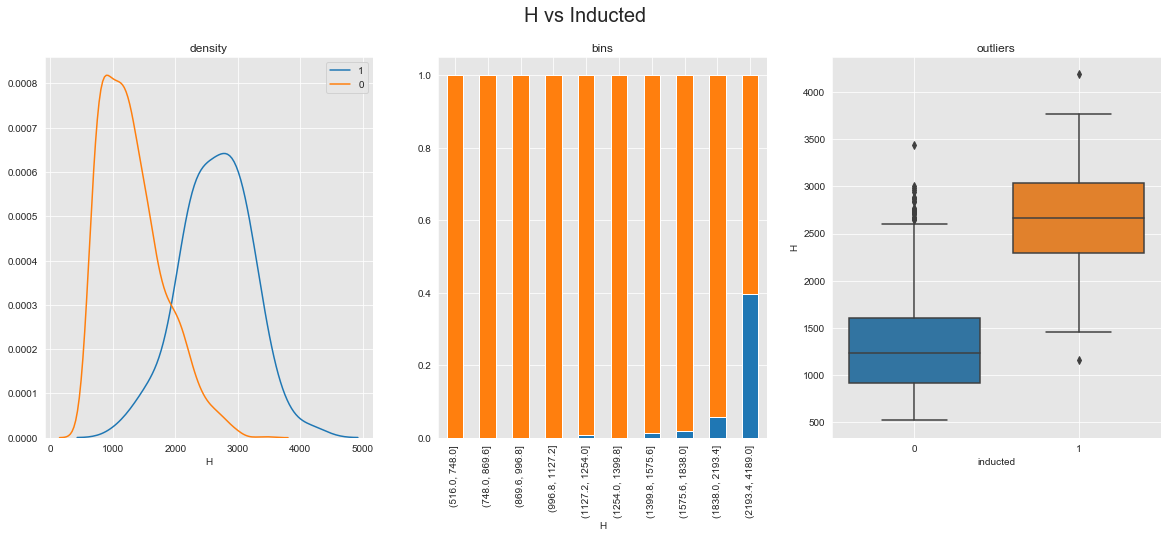

In [132]:
# Now analyze the difference in hits between the two sets of players.
comparative_graph('H')

Baseball has a ton of fun and interesting metrics but sometimes it pays to look at some of the most basic stats and listen to what they have to say. There are very few players who have over 2500 hits in their career who are not in the Hall of Fame and even less when that number reaches 3000. This is the stat that many others are built around and we can see from the graphs above correlates heavily to HOF induction.

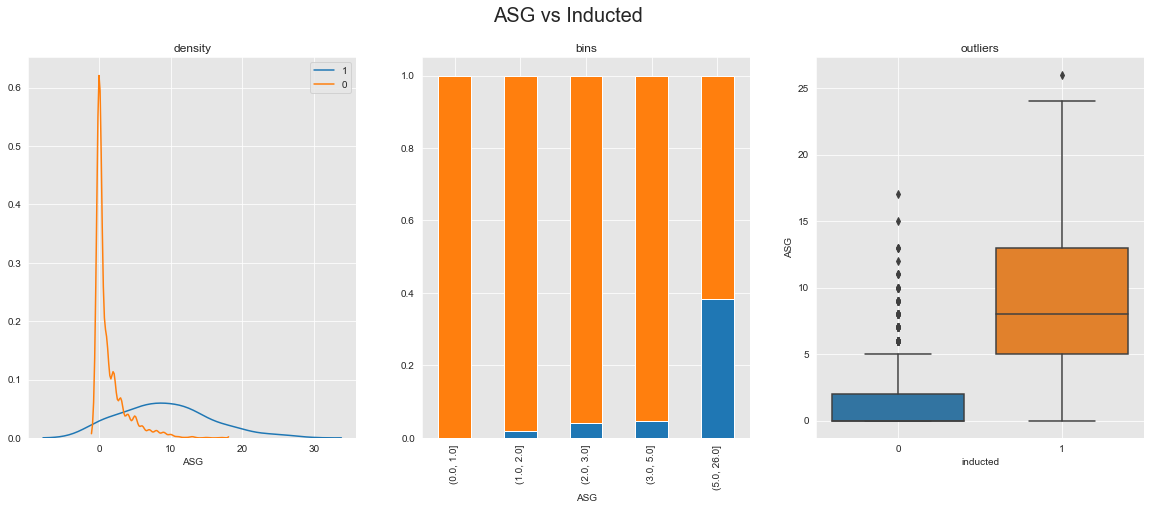

In [133]:
# Let's see how All-Star appearances can be an indicator.
comparative_graph('ASG')

Hall of Fame induction is a measure of the greatest players over the course of a career, All-Star game appearances are the same measurement for each season. Although All-Stars are voted on 2/3rds of the way through the season it's reasonable to assume that this level of play is applicable in most instances throughout the entire season.

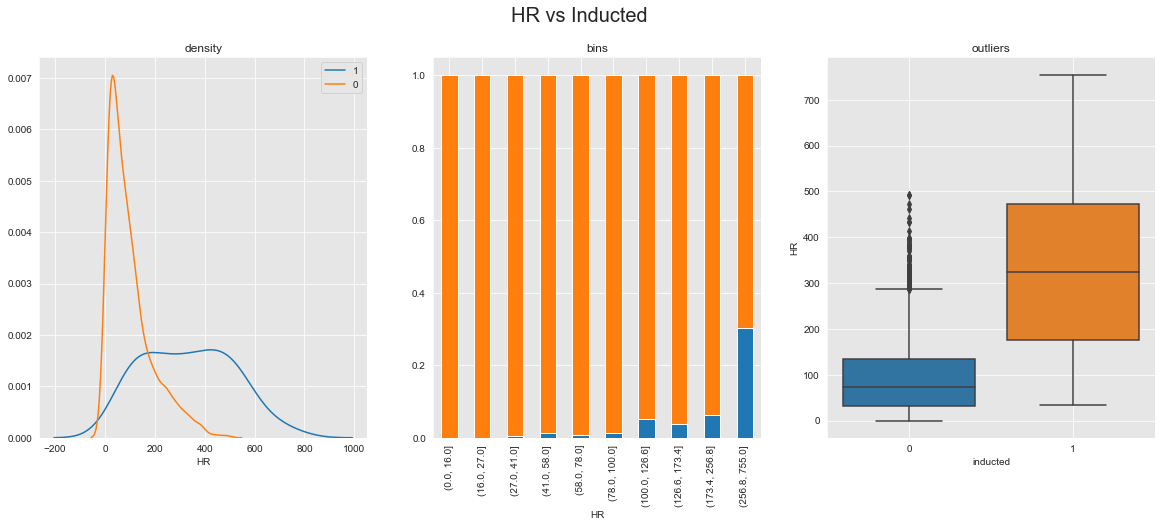

In [134]:
# Visualize HR between the two sets of batters.
comparative_graph('HR')

The most exciting play in baseball is a homerun, not only is it exciting but it's important to gain Hall of Fame consideration. We can see when looking at the density graph above that although it's certainly possible to get in without being a power hitter, there are very few players with over 400 homeruns that have not been elected into the Hall of Fame.

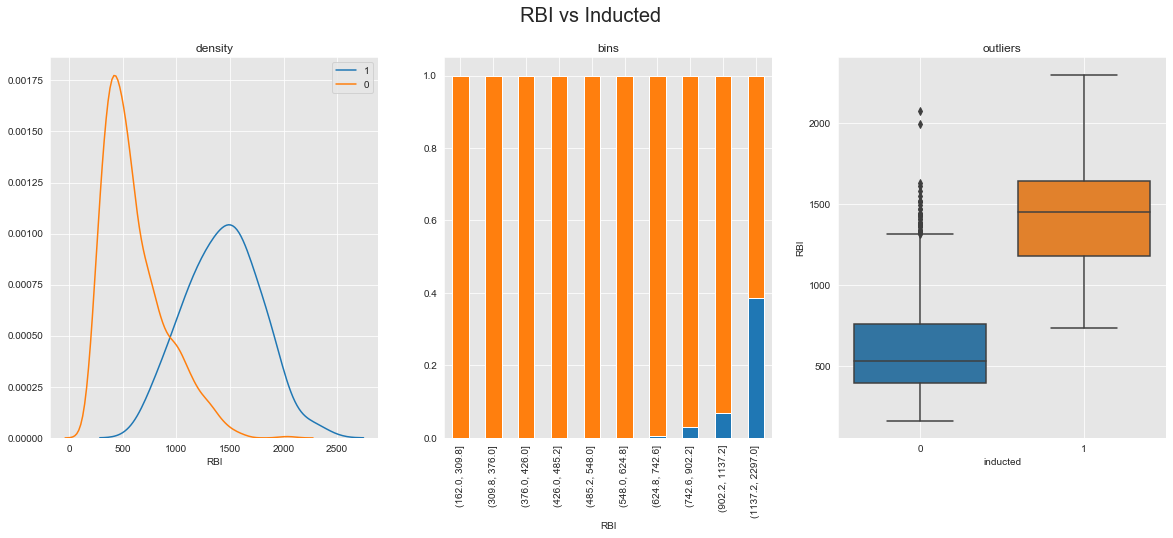

In [135]:
# Finally, let's see how RBIs compare.
comparative_graph('RBI')

Although we have several other features that we could look into, those are the six we are going to stick to at the moment. It's pretty clear from the visualizations above that each of these metrics impact Hall of Fame candidancy to a certain degree, I'll determine later the importance of each feature.

Now I want to understand which features are highly correlated and could possibly lead to multicollinearity issues in any of the models.

In [14]:
# Create a heatmap showing the correlation between features.
def heatmap(d):
    plt.figure(figsize=(20, 10))
    heatmap = sns.heatmap(d.corr(), vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

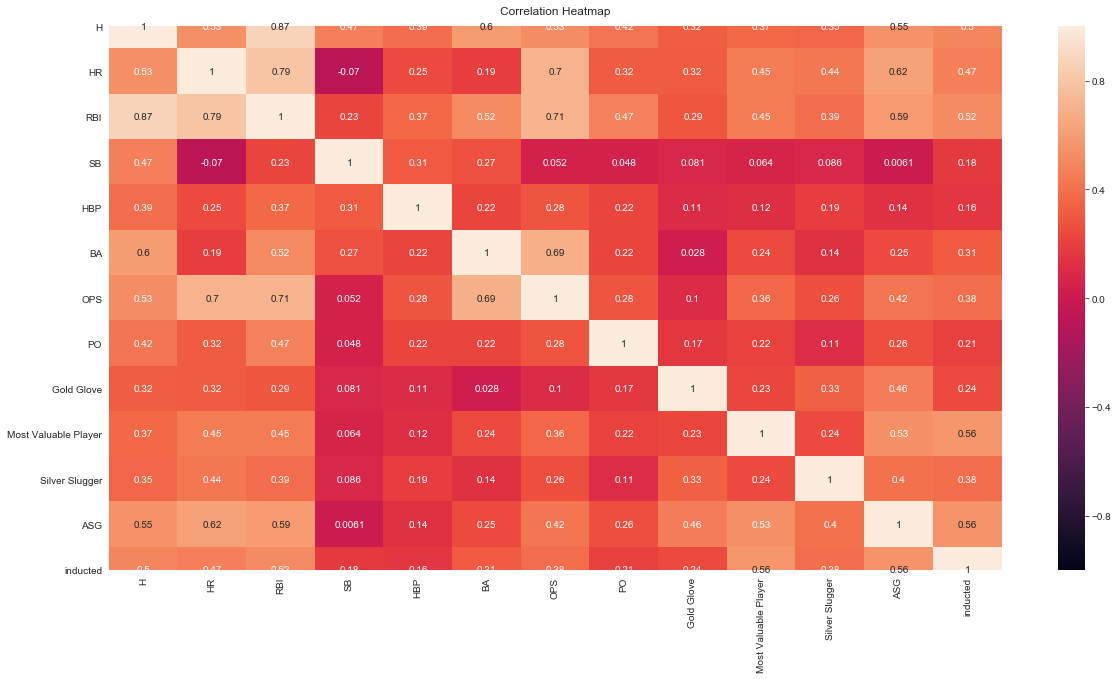

In [117]:
heatmap(df)
plt.savefig('BattingHM');

In [16]:
# Run high_corr function to determine highly correlated features.
high_corr(df)

,Correlation
Highly Correlated Pairs,
"(walks, BB)",0.995084
"(AB, H)",0.980375
"(1B, H)",0.968434
"(G, AB)",0.963961
"(SLUG, OPS)",0.953778
"(1B, AB)",0.946207
"(H, R)",0.940872
"(H, G)",0.930699
"(H, 2B)",0.925563


In [17]:
# Drop columns that are highly correlated.
df = df.drop(columns=['BB', 'AB', '1B', 'SLUG', '2B', '3B', 'CS', 'SF', 'Seasons', 'OBP', 'A', 'E', 
                      'FP', 'Hank Aaron', 'Rookie of the Year', 'walks', 'G', 'R', 'SO'])

In [18]:
high_corr(df)

,Correlation
Highly Correlated Pairs,
"(RBI, H)",0.871158
"(HR, RBI)",0.794735
"(OPS, RBI)",0.706824
"(HR, OPS)",0.704701


In [19]:
# View remaing columns.
df.columns

Index(['H', 'HR', 'RBI', 'SB', 'HBP', 'BA', 'OPS', 'PO', 'Gold Glove',
       'Most Valuable Player', 'Silver Slugger', 'ASG', 'inducted'],
      dtype='object')

# Models

Now I want to start creating a few different models to determine which is best for our data. I am going to first look at what the accuracy of our model would be if it simply classified everyone as a non-inductee. This number should be fairly high as it's am extremely selective process. From there I will build a basic Logisitic Regression model, a KNN model, a SVM model and finally a Decision Tree and Random Forest model.

In [20]:
# Look at the summary statistics for target variable.
print(df['inducted'].describe())
print('-'*30)

# What is the percentage of people who have been inducted from this dataset?
print("Mean percentage: " + str(round(np.mean(df['inducted']*100), 3)))

count    1609.000000
mean        0.049099
std         0.216142
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: inducted, dtype: float64
------------------------------
Mean percentage: 4.91


As we can see, even if we simply marked everyone as a non-inductee we would still almost have over 95% accuracy. For this project we should hope to see in the range of 97.0% to 98.5% accuracy to deem it successful.

In [21]:
# Split the data
y = df['inducted']
X = df.drop(columns=['inducted'], axis=1)

# Train the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

## print info
print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)
print("y_train mean:", round(np.mean(y_train),2), "| y_test mean:", round(np.mean(y_test),2))
print(X_train.shape[1], "features:", X_train.columns.to_list())

X_train shape: (1126, 12) | X_test shape: (483, 12)
y_train mean: 0.05 | y_test mean: 0.05
12 features: ['H', 'HR', 'RBI', 'SB', 'HBP', 'BA', 'OPS', 'PO', 'Gold Glove', 'Most Valuable Player', 'Silver Slugger', 'ASG']


# Logistic Regression

The first model I am going to explore is logisitic regression. The variables are all continuous which works well for logistic regression, it should be expected that this is one of the more accurate models.

In [22]:
# Instantiate
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model to training data
model_log = logreg.fit(X_train, y_train)

# Predict on test set
y_hat_test = logreg.predict(X_test)

In [23]:
from sklearn.metrics import roc_curve, auc

# Calculate the probability scores of each point in the training set
y_train_score = model_log.decision_function(X_train)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

# Calculate the probability scores of each point in the test set
y_score = model_log.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_score)

AUC: 0.97825311942959


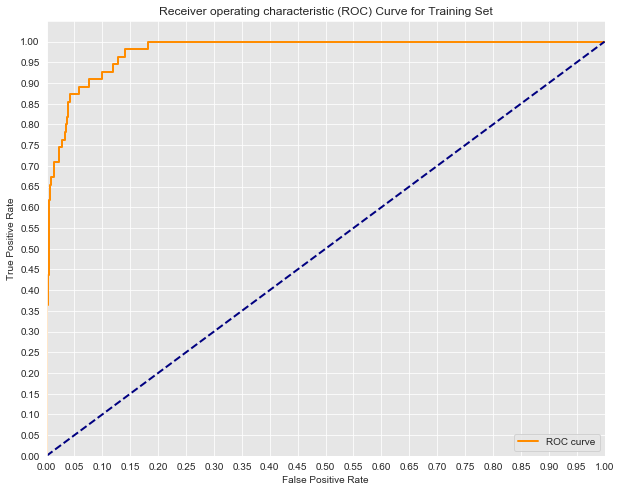

In [24]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [25]:
# Training accuracy score
logreg.score(X_train, y_train)

0.9760213143872114

Test AUC: 0.9082244008714596



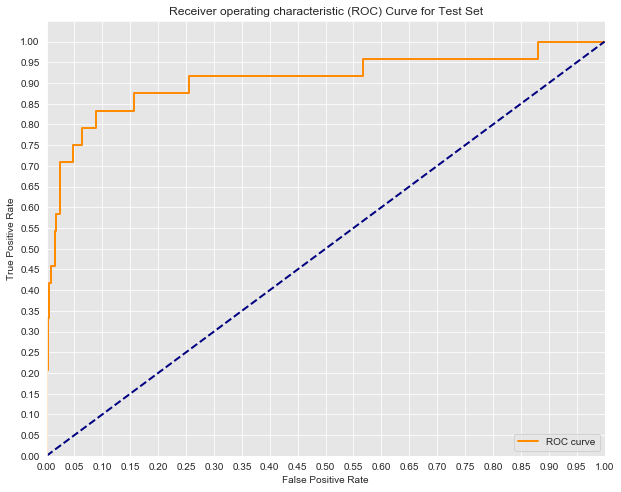

In [26]:
# ROC curve for test set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('Test AUC: {}'.format(auc(fpr, tpr)))
print('')
plt.show()

In [27]:
# Testing Accuracy Score
logreg.score(X_test, y_test)

0.9627329192546584

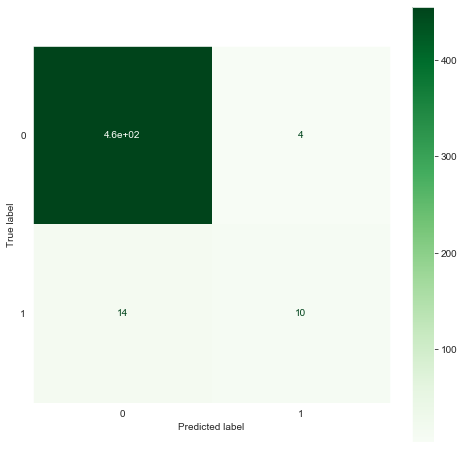

In [28]:
# Plot the confusion matrix.
plot_cm(logreg)

This logisitic regression model improved the performance less than impressively. Although there was over 96% accuracy on the test results, it inaccurately predicted 14 Hall of Famers and only got 10 correct. Additionally, the model misclassified 4 of the non-inductees as Hall of Famers. I am going to see if the model will be improved with the use of SMOTE to balance the classes.

## Logistic Regression with SMOTE

In [29]:
# Previous original class distribution
print(y_train.value_counts())

# Fit SMOTE to training data
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    1071
1      55
Name: inducted, dtype: int64


1    1071
0    1071
dtype: int64


In [30]:
# Instantiate
logreg_smote = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

# Fit the model to training data
model_log_smote = logreg_smote.fit(X_train_resampled, y_train_resampled)

# Predict on test set
y_hat_test = logreg_smote.predict(X_test)

In [31]:
# Calculate the probability scores of each point in the training set
y_train_score = model_log.decision_function(X_train_resampled)

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train_resampled, y_train_score)

# Calculate the probability scores of each point in the test set
y_score = model_log_smote.decision_function(X_test)

# Calculate the fpr, tpr, and thresholds for the test set
fpr, tpr, thresholds = roc_curve(y_test, y_score)

AUC: 0.9852402834772253


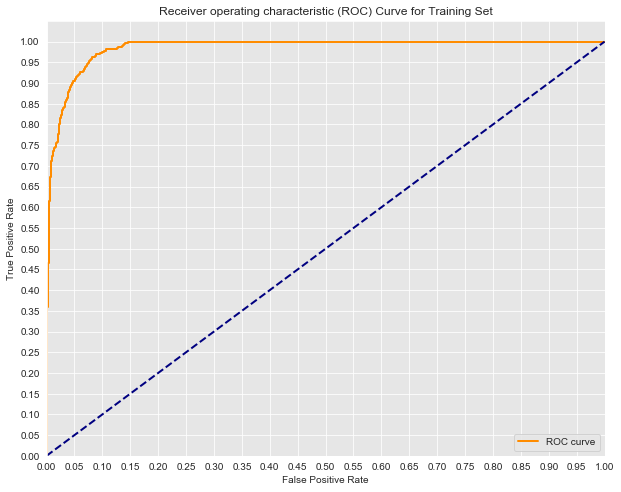

In [32]:
# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [33]:
# Training accuracy score
logreg_smote.score(X_train_resampled, y_train_resampled)

0.9509803921568627

Test AUC: 0.9021423384168483



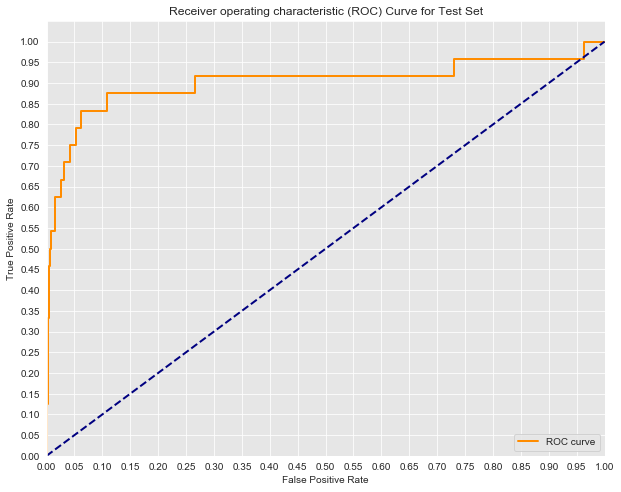

In [34]:
# ROC curve for test set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
print('Test AUC: {}'.format(auc(fpr, tpr)))
print('')
plt.show()

In [35]:
# Training accuracy score
logreg_smote.score(X_test, y_test)

0.937888198757764

That model performed even worse than if I would have just classified every player as a non-inductee. This is a significant decrease from our original model and not a viable option. The next step is tuning the parameters of our original Logistic Regression to try to find a more accurate model.

## Hyperparameter for Logistic Regression

In [36]:
model = LogisticRegression()

log_param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01, 1e12],
    'class_weight': [None, 'balanced'],
    'max_iter': [10000],
    'fit_intercept': [False] }

# define grid search
grid_log = GridSearchCV(model, log_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_log.fit(X_train, y_train)

best_parameters = grid_log.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_log = grid_log.predict(X_train)
test_preds_log = grid_log.predict(X_test)
training_accuracy_log = accuracy_score(y_train, training_preds_log)
test_accuracy_log = accuracy_score(y_test, test_preds_log)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_log * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_log * 100))

Grid Search found the following optimal parameters: 
C: 100
class_weight: None
fit_intercept: False
max_iter: 10000
penalty: 'l2'
solver: 'liblinear'

Training Accuracy: 97.51%
Testing Accuracy: 96.69%


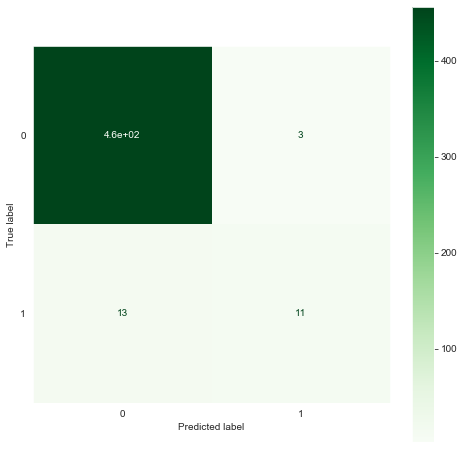

In [37]:
plot_cm(grid_log)

In [38]:
# View the metrics.
print_metrics(y_test, test_preds_log)

Precision Score: 0.7857142857142857
Recall Score: 0.4583333333333333
Accuracy Score: 0.9668737060041408
F1 Score: 0.5789473684210527


It did improve from our original model but only slightly. As it stands this is the best model but I hope to be able to greatly improve over these results. One thing to note is that the Logisitic Regression model performed very well for the ptichers and only misclassifed four of the players.

# K-Nearest Neighbors

Although my variables are all continuous and KNN works best for categorical features for arguments sake I am going to create this type of model as well. First I'll start by scaling all of the features as this is necessary in this type of analysis then I'll use the find_best_k function from above to determine the parameters. Finally, using the print_metrics function from above I will identify the precision, recall, accuracy and F1 score for this model.

In [39]:
# Instantiate StandardScaler
scaler = StandardScaler()

# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X.columns)
scaled_df_train.head()

,H,HR,RBI,SB,HBP,BA,OPS,PO,Gold Glove,Most Valuable Player,Silver Slugger,ASG
0,3.461753,3.073200,3.420102,0.371269,0.120191,0.553438,1.230885,1.850033,4.172686,2.478095,-0.262996,5.092102
1,-1.352122,-0.466555,-1.004395,-0.866120,-0.572380,-1.957079,-0.986854,-0.762698,-0.292303,-0.244183,-0.262996,-0.555943
2,1.220516,2.167892,1.585905,0.469355,0.749800,0.813146,1.622972,-0.188788,0.345552,-0.244183,1.946959,0.071618
3,-1.302583,-0.837732,-1.274638,0.514625,-0.729783,-1.221238,-1.513720,-0.831124,-0.292303,-0.244183,-0.262996,-0.242163
4,0.289515,-0.339812,-0.708279,0.401449,-0.540900,1.462418,0.177153,-0.537618,-0.292303,-0.244183,-0.262996,-0.242163


In [40]:
find_best_k(scaled_data_train, y_train, scaled_data_test, y_test)

Best Value for k: 1
F1-Score: 0.6153846153846154


In [41]:
# Instantiate KNeighborsClassifier
clf_knn = KNeighborsClassifier(n_neighbors=1)

# Fit the classifier
clf_knn.fit(scaled_data_train, y_train)

# Predict on the test set
test_preds = clf_knn.predict(scaled_data_test)

In [42]:
print_metrics(y_test, test_preds)

Precision Score: 0.8
Recall Score: 0.5
Accuracy Score: 0.968944099378882
F1 Score: 0.6153846153846154


As I assumed earlier, this model did not work very well. The accuracy score and precision score is relatively high but a low recall suggest that there are a lot of false negatives which in this case means Hall of Famers that were classified as not. We saw earlied that our accuracy would be just above 95% if we classifed every player as a non-inductee, this model did slightly better but not nearly as well as our logistic regression model.

## KNN with SMOTE

I am going to see if SMOTE will have a positive impact on the KNN model.

In [43]:
# Transform the training and test sets
scaled_data_train = scaler.fit_transform(X_train_resampled)
scaled_data_test = scaler.transform(X_test)

# Convert into a DataFrame
scaled_df_train = pd.DataFrame(scaled_data_train, columns=X.columns)
scaled_df_train.head()

,H,HR,RBI,SB,HBP,BA,OPS,PO,Gold Glove,Most Valuable Player,Silver Slugger,ASG
0,1.701329,1.231896,1.493466,0.115678,-0.205311,-0.022480,0.350578,1.153525,1.886373,0.678309,-0.566279,2.090933
1,-1.692324,-0.964628,-1.423078,-0.922679,-0.777482,-2.228307,-1.436986,-0.994873,-0.532902,-0.689388,-0.566279,-0.973033
2,0.121317,0.670125,0.284398,0.197987,0.314844,0.205709,0.666611,-0.522958,-0.187291,-0.689388,0.524483,-0.632592
3,-1.657399,-1.194954,-1.601216,0.235976,-0.907521,-1.581771,-1.861656,-1.051139,-0.532902,-0.689388,-0.566279,-0.802813
4,-0.535013,-0.885980,-1.227884,0.141004,-0.751474,0.776182,-0.498762,-0.809794,-0.532902,-0.689388,-0.566279,-0.802813


In [44]:
find_best_k(scaled_data_train, y_train_resampled, scaled_data_test, y_test)

Best Value for k: 3
F1-Score: 0.631578947368421


In [45]:
# Instantiate KNeighborsClassifier
clf_knn_smote = KNeighborsClassifier(n_neighbors=3)

# Fit the classifier
clf_knn_smote.fit(scaled_data_train, y_train_resampled)

# Predict on the test set
test_preds = clf_knn_smote.predict(scaled_data_test)

In [46]:
print_metrics(y_test, test_preds)

Precision Score: 0.5454545454545454
Recall Score: 0.75
Accuracy Score: 0.9565217391304348
F1 Score: 0.631578947368421


Unfortunately, this did not perform well either. This time we have a low precision score which simply suggests the opposite, a high number of non-inductees classified as Hall of Famers. It was a good attempt, but KNN is not the right model for this dataset.

# Support Vector Machines

Another model type that would be useful to test is support vector machines. I will compare a basic SVM to one where the data is standarized to see which offers better results. Additionally, there are a few hyperparameters, kernel perhaps being the most important, to test.

In [47]:
# Create a SVM model where we can test different kernels.
def svm(k):    
    base_svc = SVC(kernel=k)

    base_svc.fit(X_train, y_train)
    svc_prediction_train = base_svc.predict(X_train)
    svc_prediction_test = base_svc.predict(X_test)

    print('Training Accuracy Score:')
    print(accuracy_score(y_train, svc_prediction_train))

    print('Testing Accuracy Score:')
    print(accuracy_score(y_test, svc_prediction_test))
    print('-'*30)

In [48]:
# Standardize the data
std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

In [49]:
def svm_tran(k):    
    base_svc = SVC(kernel=k)

    base_svc.fit(X_train_transformed, y_train)
    svc_prediction_train = base_svc.predict(X_train_transformed)
    svc_prediction_test = base_svc.predict(X_test_transformed)

    print('Training Accuracy Score:')
    print(accuracy_score(y_train, svc_prediction_train))

    print('Testing Accuracy Score:')
    print(accuracy_score(y_test, svc_prediction_test))
    print('-'*30)

In [50]:
# Compare SVM and SVM_tran for kernel equal to rbf.
svm('rbf')
svm_tran('rbf')

Training Accuracy Score:
0.9564831261101243
Testing Accuracy Score:
0.9565217391304348
------------------------------
Training Accuracy Score:
0.9928952042628775
Testing Accuracy Score:
0.9710144927536232
------------------------------


In [51]:
# Compare SVM and SVM_tran for kernel equal to linear.
svm('linear')
svm_tran('linear')

Training Accuracy Score:
0.9715808170515098
Testing Accuracy Score:
0.9710144927536232
------------------------------
Training Accuracy Score:
0.9786856127886323
Testing Accuracy Score:
0.979296066252588
------------------------------


In [52]:
# Compare SVM and SVM_tran for kernel equal to sigmoid.
svm('sigmoid')
svm_tran('sigmoid')

Training Accuracy Score:
0.9511545293072824
Testing Accuracy Score:
0.9503105590062112
------------------------------
Training Accuracy Score:
0.9307282415630551
Testing Accuracy Score:
0.9316770186335404
------------------------------


We will replicate the base SVM adding degree as an input as is necessary for testing the polynomial kernel.

In [53]:
base_svc = SVC(kernel='poly', degree=1)

base_svc.fit(X_train, y_train)
svc_prediction_train = base_svc.predict(X_train)
svc_prediction_test = base_svc.predict(X_test)

print('Training Accuracy Score:')
print(accuracy_score(y_train, svc_prediction_train))

print('Testing Accuracy Score:')
print(accuracy_score(y_test, svc_prediction_test))
print('-'*30)

Training Accuracy Score:
0.9511545293072824
Testing Accuracy Score:
0.9503105590062112
------------------------------


In [54]:
base_svc1 = SVC(kernel='poly', degree=1)

base_svc1.fit(X_train_transformed, y_train)
svc_prediction_train1 = base_svc1.predict(X_train_transformed)
svc_prediction_test1 = base_svc.predict(X_test_transformed)

print('Training Accuracy Score:')
print(accuracy_score(y_train, svc_prediction_train1))

print('Testing Accuracy Score:')
print(accuracy_score(y_test, svc_prediction_test1))
print('-'*30)

Training Accuracy Score:
0.9769094138543517
Testing Accuracy Score:
0.9503105590062112
------------------------------


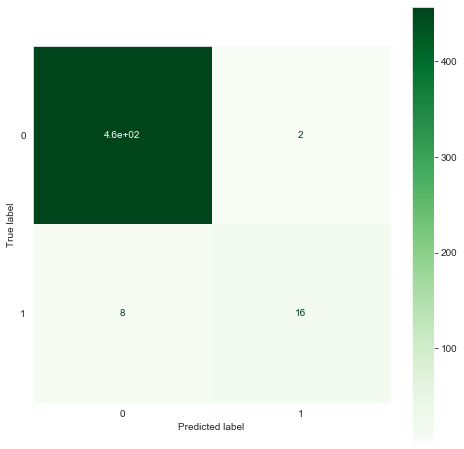

In [55]:
base_svc = SVC(kernel='linear')
base_svc.fit(X_train_transformed, y_train)
base_svc_training_preds = base_svc.predict(X_train_transformed)
base_svc_testing_preds = base_svc.predict(X_test_transformed)
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
plot_confusion_matrix(base_svc, X_test_transformed, y_test, cmap='Greens', ax=ax)

In [56]:
print_metrics(y_test, base_svc_testing_preds)

Precision Score: 0.8888888888888888
Recall Score: 0.6666666666666666
Accuracy Score: 0.979296066252588
F1 Score: 0.761904761904762


This model performed very well in comparison to our other models to this point. It classified all but 10 of the players correctly. Additionally, it classified 67% of the Hall of Famers correctly and only misclassified 2 of the non-inductees. I am going to tune the hyperparameters to see if this model can be improved even further.

## Hyperparameter for SVM

Here I will utilize GridSearchCV to find the optimal hyperparameters and try to improve on our exisiting model.

In [57]:
model = SVC()
kernel = ['linear']
C = [.0001, .001, .01, 1]
gamma = [.001, .01, 1]
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_svc = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_svc.fit(X_train_transformed, y_train)

best_parameters = grid_svc.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_svc = grid_svc.predict(X_train_transformed)
test_preds_svc = grid_svc.predict(X_test_transformed)
training_accuracy = accuracy_score(y_train, training_preds_svc)
test_accuracy = accuracy_score(y_test, test_preds_svc)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
C: 0.01
gamma: 0.001
kernel: 'linear'

Training Accuracy: 97.42%
Testing Accuracy: 97.1%


In [58]:
# Confusion matrix and classification report
print(confusion_matrix(y_test, test_preds_svc))
print(classification_report(y_test, test_preds_svc))

[[458   1]
 [ 13  11]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       459
           1       0.92      0.46      0.61        24

    accuracy                           0.97       483
   macro avg       0.94      0.73      0.80       483
weighted avg       0.97      0.97      0.97       483



Unfortunately, this model did not perform as well and the scaled SVM version of the model with the base parameters is still the best option.

# Decision Trees

Now that I have built a few models, some with great success and others that have been slightly lacking I want to look to see if any type of Tree model could improve on the accuracy. Since all of our features are continuous, there is a good chance that the previous models will outperform the following but it'll be interesting to compare the results.

In [59]:
# Instantiate and fit a DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [60]:
# Test set predictions
dt_pred = tree_clf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, dt_pred))
print(classification_report(y_test, dt_pred))

[[454   5]
 [ 10  14]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       459
           1       0.74      0.58      0.65        24

    accuracy                           0.97       483
   macro avg       0.86      0.79      0.82       483
weighted avg       0.97      0.97      0.97       483



In [61]:
tree_clf.score(X_train, y_train)

0.9937833037300178

In [62]:
tree_clf.score(X_test, y_test)

0.968944099378882

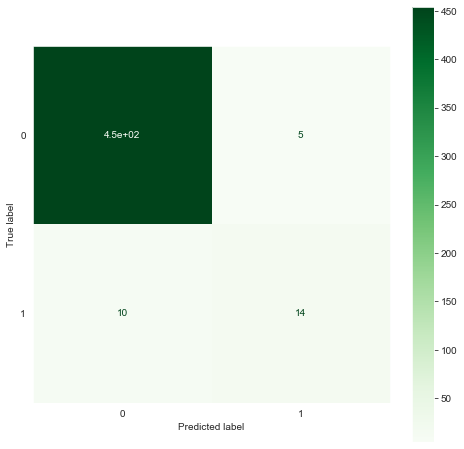

In [63]:
plot_cm(tree_clf)

In [64]:
print_metrics(y_test, dt_pred)

Precision Score: 0.7368421052631579
Recall Score: 0.5833333333333334
Accuracy Score: 0.968944099378882
F1 Score: 0.6511627906976745


Although the accuracy score of this model is slightly down from the others, it did a fairly good job classifying the Hall of Famers. There were more non-inductee misclassifications than usual which is the reason for the lower accuracy score. Keeping with the 

## Decision Tree with SMOTE

In [65]:
smote_tclf = DecisionTreeClassifier(criterion='gini', max_depth=5)
smote_tclf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [66]:
# Test set predictions
smote_tpred = smote_tclf.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, smote_tpred))
print(classification_report(y_test, smote_tpred))

[[449  10]
 [  8  16]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       459
           1       0.62      0.67      0.64        24

    accuracy                           0.96       483
   macro avg       0.80      0.82      0.81       483
weighted avg       0.96      0.96      0.96       483



In [67]:
smote_tclf.score(X_train_resampled, y_train_resampled)

0.9883286647992531

In [68]:
smote_tclf.score(X_test, y_test)

0.9627329192546584

As seems to be the theme with SMOTE, it has not increse the accuracy of the model.

## Hyperparameter

In [69]:
model = DecisionTreeClassifier()

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

# define grid search
grid_dt = GridSearchCV(model, dt_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_dt.fit(X_train, y_train)

best_parameters = grid_dt.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_dt = grid_dt.predict(X_train)
test_preds_dt = grid_dt.predict(X_test)
training_accuracy_dt = accuracy_score(y_train, training_preds_dt)
test_accuracy_dt = accuracy_score(y_test, test_preds_dt)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_dt * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_dt * 100))

Grid Search found the following optimal parameters: 
criterion: 'entropy'
max_depth: 5
min_samples_leaf: 2
min_samples_split: 10

Training Accuracy: 98.58%
Testing Accuracy: 96.48%


This did not improve our model and is far off the pace set by the SVM model.

## Bagged Trees

Our next Tree model I am going to look at is the Bagged Trees method.

In [70]:
# Instantiate a BaggingClassifier
bagged_tree = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), n_estimators=20)

In [71]:
# Fit to the training data
bagged_tree.fit(X_train, y_train)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [72]:
# Test set predictions
bagged_pred = bagged_tree.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, bagged_pred))
print(classification_report(y_test, bagged_pred))

[[457   2]
 [ 10  14]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       459
           1       0.88      0.58      0.70        24

    accuracy                           0.98       483
   macro avg       0.93      0.79      0.84       483
weighted avg       0.97      0.98      0.97       483



In [73]:
# Training accuracy score
bagged_tree.score(X_train, y_train)

0.9955595026642984

In [74]:
# Test accuracy score
bagged_tree.score(X_test, y_test)

0.9751552795031055

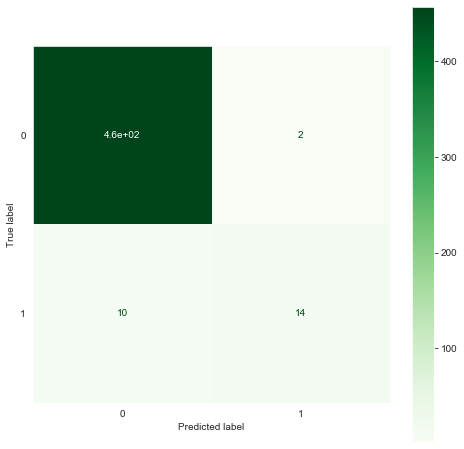

In [75]:
plot_cm(bagged_tree)

This model performed relatively well, better than the base Decision Tree model and only slightly worse than the SVM model. Perhaps with some tuning of the hyperparameters I could find a model that outperforms the SVM model but first it's time to look at the obligatory model using SMOTE.

## Bagged Trees with SMOTE

In [76]:
# Instantiate a BaggingClassifier
bagged_smote = BaggingClassifier()
# Fit to the training data
bagged_smote.fit(X_train_resampled, y_train_resampled)

BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                  max_features=1.0, max_samples=1.0, n_estimators=10,
                  n_jobs=None, oob_score=False, random_state=None, verbose=0,
                  warm_start=False)

In [77]:
# Test set predictions
smote_bpred = bagged_smote.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, smote_bpred))
print(classification_report(y_test, smote_bpred))

[[450   9]
 [ 10  14]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       459
           1       0.61      0.58      0.60        24

    accuracy                           0.96       483
   macro avg       0.79      0.78      0.79       483
weighted avg       0.96      0.96      0.96       483



In [78]:
print("Testing Accuracy for Bagged Tree Classifier with SMOTE: {:.4}%".format(accuracy_score(y_test, smote_bpred) * 100))

Testing Accuracy for Bagged Tree Classifier with SMOTE: 96.07%


Accuracy decreased significantly.

## Hyperparameter

In [79]:
model = BaggingClassifier()

bag_param_grid = {
    'n_estimators': [10, 100, 1000],
}

# define grid search
grid_bag = GridSearchCV(model, bag_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_bag.fit(X_train, y_train)

best_parameters = grid_bag.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_bags = grid_bag.predict(X_train)
test_bags = grid_bag.predict(X_test)
training_accuracy_bags = accuracy_score(y_train, training_bags)
test_accuracy_bags = accuracy_score(y_test, test_bags)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_bags * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_bags * 100))

Grid Search found the following optimal parameters: 
n_estimators: 100

Training Accuracy: 100.0%
Testing Accuracy: 97.52%


The original baseline Bagging classifier and this one performed just about the same and are not accurate enough to replace the SVM model.

## Random Forest

The next model that I will consider is the Random Forest model.

In [80]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [81]:
# Training accuracy score
forest.score(X_train, y_train)

0.9928952042628775

In [82]:
# Test accuracy score
forest.score(X_test, y_test)

0.9751552795031055

In [83]:
# Test set predictions
rf_pred = forest.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

[[457   2]
 [ 10  14]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       459
           1       0.88      0.58      0.70        24

    accuracy                           0.98       483
   macro avg       0.93      0.79      0.84       483
weighted avg       0.97      0.98      0.97       483



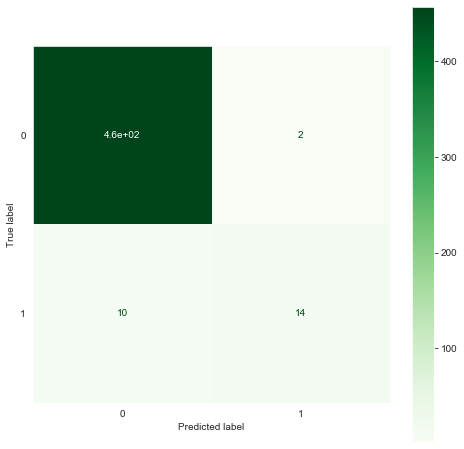

In [84]:
plot_cm(forest)

In [85]:
print_metrics(y_test, rf_pred)

Precision Score: 0.875
Recall Score: 0.5833333333333334
Accuracy Score: 0.9751552795031055
F1 Score: 0.7000000000000001


The Random Forest model appears to be suffering from overfitting and a poor recall score in comparison to the precision score. With that in consideration, the accuracy score is among the top of all the models so far. I am going to try to improve the model with SMOTE and hyperparameter tuning.

## Random Forest with SMOTE

In [86]:
# Instantiate and fit a RandomForestClassifier
smote_forest = RandomForestClassifier(n_estimators=100, max_depth=5)
smote_forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [87]:
# Training accuracy score
smote_forest.score(X_train_resampled, y_train_resampled)

0.9878618113912232

In [88]:
# Test accuracy score
smote_forest.score(X_test, y_test)

0.9648033126293996

In [89]:
# Test set predictions
srf_pred = smote_forest.predict(X_test)

# Confusion matrix and classification report
print(confusion_matrix(y_test, srf_pred))
print(classification_report(y_test, srf_pred))

[[449  10]
 [  7  17]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       459
           1       0.63      0.71      0.67        24

    accuracy                           0.96       483
   macro avg       0.81      0.84      0.82       483
weighted avg       0.97      0.96      0.97       483



Unfortunately, SMOTE once again decrease the accuracy of the model.

## Hyperparameter Tuning

In [109]:
model = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [10, 100, 1000],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

# define grid search
grid_rf = GridSearchCV(model, rf_param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_parameters = grid_rf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_rf = grid_rf.predict(X_train)
test_preds_rf = grid_rf.predict(X_test)
training_accuracy_rf = accuracy_score(y_train, training_preds_rf)
test_accuracy_rf = accuracy_score(y_test, test_preds_rf)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_rf * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_rf * 100))

Grid Search found the following optimal parameters: 
criterion: 'gini'
max_depth: None
max_features: 'sqrt'
min_samples_leaf: 3
min_samples_split: 5
n_estimators: 100

Training Accuracy: 99.2%
Testing Accuracy: 97.52%


This is one of the best models for this dataset yet. The SVM model has a slightly higher testing accuracy score and has no sign of overfitting. For that reason the SVM model is the better of the two for this analysis.

# Extreme Gradient Boosting

In [91]:
# Instantiate XGBClassifier
clf = XGBClassifier()

# Fit XGBClassifier
clf.fit(X_train, y_train)

# Predict on training and test sets
training_preds = clf.predict(X_train)
test_preds = clf.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Testing Accuracy: 97.52%


This model had great training accuracy but struggled to perform to that same standard with the testing accuracy. I will tune the hyperparameters to see if this model can be improved or if the SVM model is in fact the best for this analysis.

## Hyperparameter Tuning

In [92]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 100, 1000],
}

In [93]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.001
max_depth: 3
min_child_weight: 1
n_estimators: 1000
subsample: 0.5

Training Accuracy: 98.58%
Testing Accuracy: 96.48%


This model perfomed worse than the base XGB model and did not outperform the SVM model which means that I am going to move forward with the SVM model to see if I can make any further changes to improve that model's performance.

# Evaluation

Although there were a few good options such as Logisitic Regression and Bagging, the SVM model outperformed the others. This model has been tuned using an array of hyperparameters to find what works best; however, it might benefit the model to log transform the features. Due to the fact that there are several zeros in the dataset I will do log + 1 in order to work around that. The last thing I want to look at is the feature importance to determine if there are any that can be dropped for improved model performance!

In [94]:
# Run log function for the features.
log_features = X.columns
log_transform(X, log_features)

,H,HR,RBI,SB,HBP,BA,OPS,PO,Gold Glove,Most Valuable Player,...,RBI_log,SB_log,HBP_log,BA_log,OPS_log,PO_log,Gold Glove_log,Most Valuable Player_log,Silver Slugger_log,ASG_log
0,3771,755,2297.0,240.0,32.0,0.305,0.929,7436.0,3.0,1.0,...,7.739794,5.484797,3.496508,0.266203,0.657002,8.914223,1.386294,0.693147,0.000000,3.218876
1,772,11,324.0,142.0,33.0,0.254,0.650,1873.0,0.0,0.0,...,5.783825,4.962845,3.526361,0.226338,0.500775,7.535830,0.000000,0.000000,0.000000,0.000000
2,2470,288,1363.0,400.0,33.0,0.291,0.870,3952.0,1.0,0.0,...,7.218177,5.993961,3.526361,0.255417,0.625938,8.282230,0.693147,0.000000,0.693147,1.098612
3,1022,57,366.0,29.0,17.0,0.254,0.639,2380.0,0.0,0.0,...,5.905362,3.401197,2.890372,0.226338,0.494086,7.775276,0.000000,0.000000,0.000000,0.000000
4,1082,37,303.0,67.0,17.0,0.269,0.708,1748.0,0.0,0.0,...,5.717028,4.219508,2.890372,0.238229,0.535323,7.466799,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616,1093,237,776.0,15.0,24.0,0.265,0.815,2287.0,0.0,0.0,...,6.655440,2.772589,3.218876,0.235072,0.596085,7.735433,0.000000,0.000000,0.000000,0.693147
1617,1225,26,625.0,151.0,91.0,0.269,0.708,5121.0,0.0,0.0,...,6.439350,5.023881,4.521789,0.238229,0.535323,8.541300,0.000000,0.000000,0.000000,0.000000
1618,773,91,352.0,45.0,13.0,0.235,0.662,1641.0,0.0,0.0,...,5.866468,3.828641,2.639057,0.211071,0.508022,7.403670,0.000000,0.000000,0.000000,1.098612
1619,1566,58,796.0,175.0,38.0,0.295,0.750,2394.0,0.0,0.0,...,6.680855,5.170484,3.663562,0.258511,0.559616,7.781139,0.000000,0.000000,0.000000,0.000000


In [95]:
# Drop all of the original features as to keep only the log transformations.
X_log = X.drop(columns=['H', 'HR', 'RBI', 'SB', 'HBP', 'BA', 'OPS', 'PO', 
                        'Gold Glove', 'Most Valuable Player', 'Silver Slugger', 'ASG'], axis=1)
X_log.head()

,H_log,HR_log,RBI_log,SB_log,HBP_log,BA_log,OPS_log,PO_log,Gold Glove_log,Most Valuable Player_log,Silver Slugger_log,ASG_log
0,8.235361,6.628041,7.739794,5.484797,3.496508,0.266203,0.657002,8.914223,1.386294,0.693147,0.000000,3.218876
1,6.650279,2.484907,5.783825,4.962845,3.526361,0.226338,0.500775,7.535830,0.000000,0.000000,0.000000,0.000000
2,7.812378,5.666427,7.218177,5.993961,3.526361,0.255417,0.625938,8.282230,0.693147,0.000000,0.693147,1.098612
3,6.930495,4.060443,5.905362,3.401197,2.890372,0.226338,0.494086,7.775276,0.000000,0.000000,0.000000,0.000000
4,6.987490,3.637586,5.717028,4.219508,2.890372,0.238229,0.535323,7.466799,0.000000,0.000000,0.000000,0.000000


In [96]:
# Train the data.
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y, test_size=.30, random_state=42)

# Print the info.
print("X_train shape:", X_train_log.shape, "| X_test shape:", X_test_log.shape)
print("y_train mean:", round(np.mean(y_train_log),2), "| y_test mean:", round(np.mean(y_test_log),2))
print(X_train_log.shape[1], "features:", X_train_log.columns.to_list())

X_train shape: (1126, 12) | X_test shape: (483, 12)
y_train mean: 0.05 | y_test mean: 0.05
12 features: ['H_log', 'HR_log', 'RBI_log', 'SB_log', 'HBP_log', 'BA_log', 'OPS_log', 'PO_log', 'Gold Glove_log', 'Most Valuable Player_log', 'Silver Slugger_log', 'ASG_log']


In [97]:
# Run the hyperparameter search on the log transformed features.

model = SVC()
kernel = ['linear']
C = [.0001, .001, .01, 1]
gamma = [.001, .01, 1]
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_svc_log = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_svc_log.fit(X_train_log, y_train_log)

best_parameters = grid_svc_log.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_log = grid_svc_log.predict(X_train_log)
test_preds_log = grid_svc_log.predict(X_test_log)
training_accuracy_log = accuracy_score(y_train_log, training_preds_log)
test_accuracy_log = accuracy_score(y_test_log, test_preds_log)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_log * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_log * 100))

Grid Search found the following optimal parameters: 
C: 1
gamma: 0.001
kernel: 'linear'

Training Accuracy: 97.42%
Testing Accuracy: 96.89%


Unfortunately, a log transformation of the features did not result in a boosted model performance. One last effort to improve my model is going to come from analyzing the feature importance. Perhaps dropping some of the least important features will have a positive impact. 

In [99]:
# Use the optimized parameters for the model and fit it to our training data.
svm = SVC(gamma=0.001, C=1, kernel = 'linear')
svm.fit(X_train_transformed, y_train)

# Define the model features.
model_features = ['H', 'HR', 'RBI', 'SB', 'HBP', 'BA', 'OPS', 'PO', 'Gold Glove',
       'Most Valuable Player', 'Silver Slugger', 'ASG']

# Create a dictionary of features and accompanying coefficients.
coef_dict = {}
for coef, feat in zip(abs(svm.coef_[0,:]),model_features):
    coef_dict[feat] = coef
coef_dict

{'H': 0.6367477278307336,
 'HR': 0.47005754553311585,
 'RBI': 0.26610682361352955,
 'SB': 0.27889044347926006,
 'HBP': 0.0273378768616217,
 'BA': 0.2890714673095416,
 'OPS': 0.19137906616085743,
 'PO': 0.18364105404722397,
 'Gold Glove': 0.06798361239416012,
 'Most Valuable Player': 0.12426559009564944,
 'Silver Slugger': 0.08717079248290188,
 'ASG': 0.5264213122369701}

In [100]:
# Transform the dictionary to a DataFrame in order to visualize.
feature_df = pd.DataFrame.from_dict(coef_dict, orient='index').reset_index()
feature_df.columns = ['Features', 'Coefs']
feature_df = feature_df.sort_values(by='Coefs', ascending=False)
feature_df

,Features,Coefs
0,H,0.636748
11,ASG,0.526421
1,HR,0.470058
5,BA,0.289071
3,SB,0.278890
2,RBI,0.266107
6,OPS,0.191379
7,PO,0.183641
9,Most Valuable Player,0.124266
10,Silver Slugger,0.087171


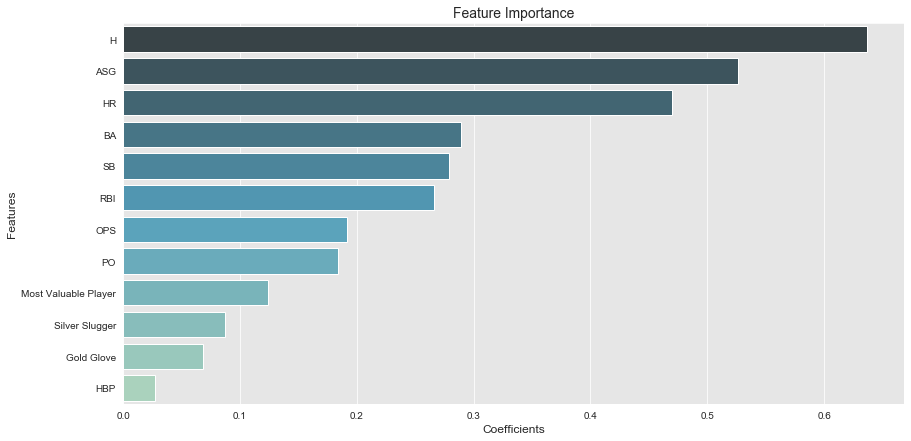

In [116]:
#Plot the above findings.
plt.figure(figsize=(14,7))
ax4 = sns.barplot(x=feature_df['Coefs'], y=feature_df['Features'], palette='GnBu_d')
plt.xlabel('Coefficients', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.savefig('FeatureImportanceBatter');

I am going to drop the bottom three features to see if it improves our model performance.

In [102]:
# Drop all of the original features as to keep only the log transformations.
X_1 = X.drop(columns=['H_log', 'HR_log', 'RBI_log', 'SB_log', 'HBP_log', 'BA_log', 'OPS_log', 
                      'PO_log', 'Gold Glove_log', 'Most Valuable Player_log', 'Silver Slugger_log', 
                      'ASG_log', 'HBP', 'Gold Glove', 'Silver Slugger'], axis=1)
X_1.head()

,H,HR,RBI,SB,BA,OPS,PO,Most Valuable Player,ASG
0,3771,755,2297.0,240.0,0.305,0.929,7436.0,1.0,24.0
1,772,11,324.0,142.0,0.254,0.650,1873.0,0.0,0.0
2,2470,288,1363.0,400.0,0.291,0.870,3952.0,0.0,2.0
3,1022,57,366.0,29.0,0.254,0.639,2380.0,0.0,0.0
4,1082,37,303.0,67.0,0.269,0.708,1748.0,0.0,0.0


In [103]:
# Train the data.
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y, test_size=.30, random_state=42)

# Print the info.
print("X_train shape:", X_train_1.shape, "| X_test shape:", X_test_1.shape)
print("y_train mean:", round(np.mean(y_train_1),2), "| y_test mean:", round(np.mean(y_test_1),2))
print(X_train_1.shape[1], "features:", X_train_1.columns.to_list())

X_train shape: (1126, 9) | X_test shape: (483, 9)
y_train mean: 0.05 | y_test mean: 0.05
9 features: ['H', 'HR', 'RBI', 'SB', 'BA', 'OPS', 'PO', 'Most Valuable Player', 'ASG']


In [104]:
# Standardize the data
std = StandardScaler()
X_train_transformed_1 = std.fit_transform(X_train_1)
X_test_transformed_1 = std.transform(X_test_1)

In [105]:
# Run the hyperparameter search on the new list of features.
model = SVC()
kernel = ['linear']
C = [.0001, .001, .01, 1]
gamma = [.001, .01, 1]
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_svc_1 = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_svc_1.fit(X_train_transformed_1, y_train_1)

best_parameters = grid_svc_1.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds_1 = grid_svc_1.predict(X_train_transformed_1)
test_preds_1 = grid_svc_1.predict(X_test_transformed_1)
training_accuracy_1 = accuracy_score(y_train_1, training_preds_1)
test_accuracy_1 = accuracy_score(y_test_1, test_preds_1)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy_1 * 100))
print('Testing Accuracy: {:.4}%'.format(test_accuracy_1 * 100))

Grid Search found the following optimal parameters: 
C: 1
gamma: 0.001
kernel: 'linear'

Training Accuracy: 97.96%
Testing Accuracy: 97.72%


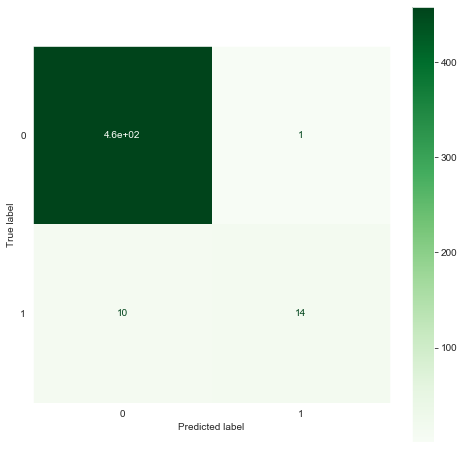

In [106]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
plot_confusion_matrix(grid_svc_1, X_test_transformed_1, y_test_1, cmap='Greens', ax=ax)

In [107]:
print_metrics(y_test_1, test_preds_1)

Precision Score: 0.9333333333333333
Recall Score: 0.5833333333333334
Accuracy Score: 0.9772256728778468
F1 Score: 0.7179487179487181


Dropping those 3 less significant features did not have the desired impact on our model that we had hoped for, at this point I am satisfied with the optimized SVM model we created earlier. Due to the nature of Hall of Fame voting which is subjected to the opinion of Baseball writers voting on a game that has greatly changed over the century there is always going to be room for a few inaccurate predictions. Let's take one last look at the key metrics of our SVM model and make recommendations based on those.

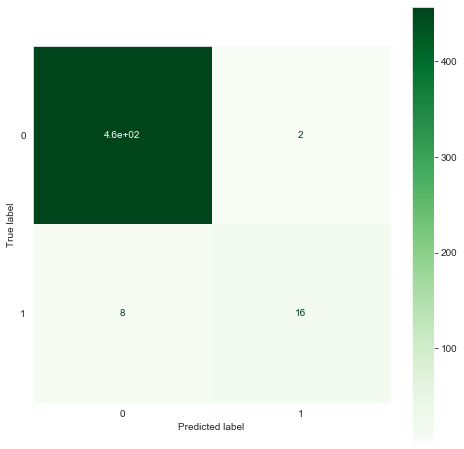

In [115]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.grid(False)
plot_confusion_matrix(base_svc, X_test_transformed, y_test, cmap='Greens', ax=ax)
plt.savefig('BattingCM');

In [111]:
print_metrics(y_test, base_svc_testing_preds)

Precision Score: 0.8888888888888888
Recall Score: 0.6666666666666666
Accuracy Score: 0.979296066252588
F1 Score: 0.761904761904762


# Recommendations

When considering who should be inducted in the Major League Baseball Hall of Fame, I would recommend the following:

1. When analyzing the past performances in order to make a decision on future inductees, remove those individuals who have not been elected due to non-performance related issues such as Performance Enhancing Drugs and scandals detrimental to the sport.
2. When reviewing a player, some of the key areas to focus on should be MVP, Silver Slugger, Gold Glove and All-Star game appearances. There are several others but when analyzing what has had the most impact on voting in the past, those features were most predominant.
3. Take into consideration which is more important, that there are no individuals who deserve to be in the Hall of Fame left out, that no one who doesn't deserve be let in or perhaps a combination of both. It is my recommendation that neither is more important than the other.
4. It is important when considering a player for induction that not too much emphasis be placed on two sets of statistics that are highly correlated, otherwise it'll give additional the value to each.
5. Although fielding is an important part of the game, most of the value of a Hall of Famer comes from the pitching or hitting statistics and to stay consistent with past voting should carry most of the weight.

# Future Work

There are several other considerations that I would like to make in the future.

1. Consider all Hall of Fame inductees, not just those voted in by the Baseball Writers of America.
2. Further analyze how position impacts the Hall of Fame voting, for instance a catcher should be compared to other catchers rather than all position players.
3. Which players who have currently played at least ten seasons and have not yet been eligible for HOF voting are likely to be elected based on the analysis.
4. Incorporate the era that an individual played into the model. The game and the individual statistics have changed so much over the last 100 years that it's reasonable to assuem this is having an impact on the model.